In [2]:
# Import libraries
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

In [3]:
adult_df_large = pd.read_csv("adult.csv")
g50k = adult_df_large[adult_df_large["income"] == ">50K"]
leq50k_sample = adult_df_large[adult_df_large["income"] == "<=50K"].sample(
    g50k.shape[0]
)
census_df = pd.concat([g50k, leq50k_sample])
census_df.shape

(15682, 15)

In [4]:
train_df, test_df = train_test_split(census_df, test_size = 0.2, random_state = 123) # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["income"]), train_df["income"] 
X_test, y_test = test_df.drop(columns=["income"]), test_df["income"]
train_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25510,33,Private,112900,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
2444,38,Federal-gov,238342,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,7688,0,42,United-States,>50K
2039,46,Local-gov,121124,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,40,United-States,>50K
7529,51,Self-emp-inc,304955,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
22427,47,Private,147236,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K


In [5]:
train_df.sort_index().head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
11,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,>50K


In [6]:
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

In [7]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race',
                       'sex', 'native.country']
remainder_features = []
#not income because it's a target output. 

In [8]:
# from pandas_profiling import ProfileReport
# ProfileReport(train_df)

In [9]:
train_df_nan.info()
train_df_nan.describe(include = "all")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12545 entries, 25510 to 10168
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             12545 non-null  int64 
 1   workclass       12011 non-null  object
 2   fnlwgt          12545 non-null  int64 
 3   education       12545 non-null  object
 4   education.num   12545 non-null  int64 
 5   marital.status  12545 non-null  object
 6   occupation      12010 non-null  object
 7   relationship    12545 non-null  object
 8   race            12545 non-null  object
 9   sex             12545 non-null  object
 10  capital.gain    12545 non-null  int64 
 11  capital.loss    12545 non-null  int64 
 12  hours.per.week  12545 non-null  int64 
 13  native.country  12336 non-null  object
 14  income          12545 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.5+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,12545.000000,12011,1.254500e+04,12545,12545.000000,12545,12010,12545,12545,12545,12545.000000,12545.000000,12545.000000,12336,12545
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Exec-managerial,Husband,White,Male,NaN,NaN,NaN,United-States,>50K
freq,NaN,8478,NaN,3632,NaN,7477,2141,6607,11008,9141,NaN,NaN,NaN,11387,6281
mean,40.538541,NaN,1.888356e+05,NaN,10.599681,NaN,NaN,NaN,NaN,NaN,2085.367796,125.364528,42.086010,NaN,NaN
std,12.977541,NaN,1.047164e+05,NaN,2.602546,NaN,NaN,NaN,NaN,NaN,10498.116233,482.144969,12.202546,NaN,NaN
min,17.000000,NaN,1.487800e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,31.000000,NaN,1.180250e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,40.000000,NaN,1.774650e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,49.000000,NaN,2.349010e+05,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,50.000000,NaN,NaN


C:\Users\Daniel\miniconda3\envs\571\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


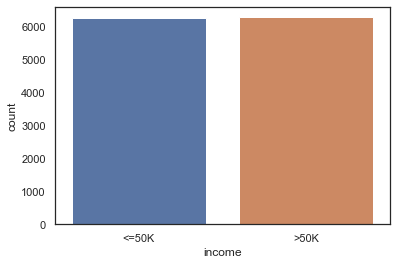

In [10]:
sns.countplot(train_df_nan['income'],label="Count")
plt.show()

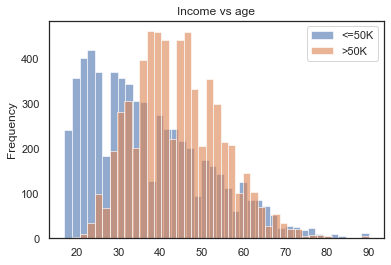

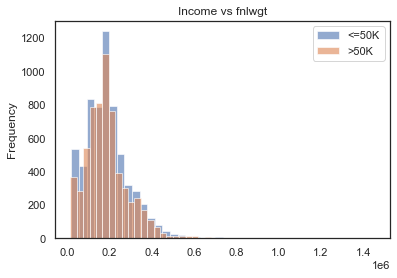

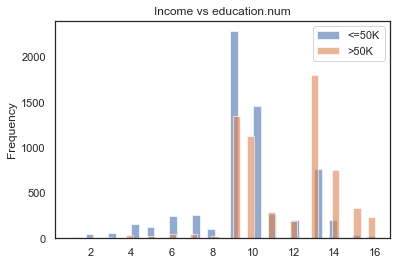

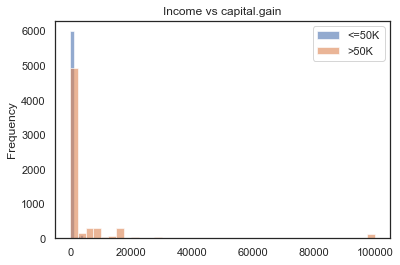

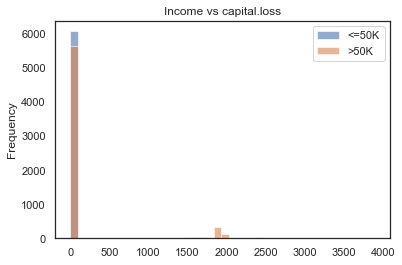

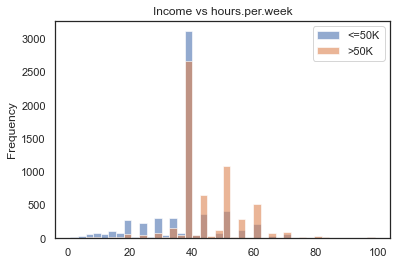

In [11]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
#group features to get distribution for both income levels (above and below 50k)
for feature in numeric_features: 
    #feature is row
    ax = train_df_nan.groupby("income")[feature].plot.hist(bins = 40, alpha = 0.6, legend = True)
    plt.title("Income vs " + feature)
    plt.show()

age, fnlwgt, education.num, and hours.per.week have the biggest spread and seem to be good predictors. 

In [12]:
X_train, y_train = train_df_nan.drop(columns=["income"]), train_df["income"] 
X_test, y_test = test_df_nan.drop(columns=["income"]), test_df["income"]

In [13]:
X_train.isna().sum()

age                 0
workclass         534
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation        535
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    209
dtype: int64

>I included imputation on every quality, because I expect NANs for most natural data sets. 

>scaling for all numerical qualities - 'age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'

>one-hot encoding for all categorical columns: 'workclass', 'eduation', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'

In [14]:
imputer = SimpleImputer(strategy="median")

imputer.fit(X_train[numeric_features])
#fit on train ONLY !
X_train_imp_num = imputer.transform(X_train[numeric_features])
X_test_imp_num = imputer.transform(X_test[numeric_features])

In [15]:
imputer = SimpleImputer(strategy="constant", fill_value = "missing")

imputer.fit(X_train[categorical_features])
X_train_imp_cat = imputer.transform(X_train[categorical_features])
X_test_imp_cat = imputer.transform(X_test[categorical_features])

In [16]:
df_X_train_imp_cat = pd.DataFrame(X_train_imp_cat, columns = categorical_features, index = X_train.index)
df_X_train_imp_cat

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
25510,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,United-States
2444,Federal-gov,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,United-States
2039,Local-gov,Bachelors,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
7529,Self-emp-inc,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
22427,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
...,...,...,...,...,...,...,...,...
18851,Private,Bachelors,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
31311,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male,United-States
2100,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,United-States
7701,Private,Some-college,Never-married,Sales,Not-in-family,White,Female,United-States


In [17]:
print(df_X_train_imp_cat.isnull().any(axis=0))

workclass         False
education         False
marital.status    False
occupation        False
relationship      False
race              False
sex               False
native.country    False
dtype: bool


In [18]:
ohe_cat = OneHotEncoder(sparse=False, dtype="int")
ohe_cat.fit(X_train_imp_cat)

X_train_imp_cat_ohe = ohe_cat.transform(X_train_imp_cat)
X_test_imp_cat_ohe = ohe_cat.transform(X_test_imp_cat)
ohe_cat.categories_

[array(['Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay',
        'missing'], dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty',
        'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving',
        'missing'], dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-I

In [20]:
X_train_pp = np.hstack((X_train_imp_num, X_train_imp_cat_ohe))
X_test_pp = np.hstack((X_test_imp_num, X_test_imp_cat_ohe))

print(f"X_train_pp shape is {X_train_pp.shape}")
print(f"X_test_pp shape is {X_test_pp.shape}")
# X_train_pp.shape

X_train_pp shape is (12545, 107)
X_test_pp shape is (3137, 107)


In [21]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train_pp, y_train, cv = 5, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.981057,0.600005,0.597848,0.744619
1,1.040001,0.633962,0.599841,0.743523
2,0.944000,0.590518,0.605022,0.740235
3,1.020576,0.642945,0.597051,0.745317
4,0.867487,0.493994,0.596253,0.737346


## Using sklearn.pipeline.Pipeline

In [22]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [30]:
preprocessor.fit(X_train, y_train)
X_train_pp = preprocessor.transform(X_train)
preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(categorical_features)

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'workclass_missing', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital.status_Divorced',
       'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent',
       'marital.status_Never-married', 'marital.status_Separated',
       'marital.status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occ

## Building models
<hr>

In [31]:
results_dict = {}

In [32]:
### Adapted Code
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_validation_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_test_score": "{:0.4f}".format(scores["test_score"].std()),
    }

In [33]:
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("dummy", DummyClassifier(strategy = "prior")),
    ]
)

scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
store_cross_val_results("dummy", scores, results_dict)

pd.DataFrame(results_dict).T

,mean_fit_time (s),mean_score_time (s),mean_train_accuracy,mean_validation_accuracy,std_test_score,std_train_score
dummy,0.1078,0.0352,0.5007,0.5007,0.0002,0.0000


## Testing different models

In [34]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

In [35]:
for key, value in models.items():
    pipe2 = make_pipeline(preprocessor, value)
    scores2 = cross_validate(pipe2, X_train, y_train, cv=5, return_train_score=True)
    store_cross_val_results(value, scores2, results_dict)

pd.DataFrame(results_dict).T

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5007,0.5007,0.1078,0.0352,0.0000,0.0002
DecisionTreeClassifier(),1.0000,0.7721,0.8510,0.0458,0.0000,0.0087
KNeighborsClassifier(),0.8524,0.7934,0.1286,2.7259,0.0018,0.0057
SVC(),0.8439,0.8264,5.2393,0.6727,0.0011,0.0077


> The DTC has the best accuracy, while the dummy and the KNN have the fastest fit times, while the dummy and DTC have the fastest score times. 

### Exploring scaling

In [36]:
numeric_transformer_unscaled = make_pipeline(SimpleImputer(strategy="median"))

preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_unscaled, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

for model_name, model in models.items():
    pipe_unscaled = Pipeline(
        steps=[("preprocessor", preprocessor_unscaled), ("classifier", model)]
    )
    scores = cross_validate(
        pipe_unscaled, X_train, y_train, cv=5, return_train_score=True
    )
    store_cross_val_results(model_name + "_unscaled", scores, results_dict)

results_df = pd.DataFrame(results_dict).T
results_df

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5007,0.5007,0.1078,0.0352,0.0000,0.0002
DecisionTreeClassifier(),1.0000,0.7721,0.8510,0.0458,0.0000,0.0087
KNeighborsClassifier(),0.8524,0.7934,0.1286,2.7259,0.0018,0.0057
SVC(),0.8439,0.8264,5.2393,0.6727,0.0011,0.0077
decision tree_unscaled,1.0000,0.7738,0.3378,0.0168,0.0000,0.0067
kNN_unscaled,0.7422,0.5992,0.0580,1.1913,0.0030,0.0031
RBF SVM_unscaled,0.5792,0.5780,6.2268,1.1989,0.0022,0.0051


> Looks like scaling doesn't help here

### Hyperparameter optimization

In [37]:
param_grid = {"C": np.logspace(-3, 2, 6)}

In [38]:
for x in param_grid["C"]:
    pipe3 = make_pipeline(preprocessor, SVC(C=x))
    store_cross_val_results(f"SVM{x}",
    cross_validate(pipe3, X_train, y_train, cv = 5, return_train_score = True), results_dict)

pd.DataFrame(results_dict).T

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5007,0.5007,0.1078,0.0352,0.0000,0.0002
DecisionTreeClassifier(),1.0000,0.7721,0.8510,0.0458,0.0000,0.0087
KNeighborsClassifier(),0.8524,0.7934,0.1286,2.7259,0.0018,0.0057
SVC(),0.8439,0.8264,5.2393,0.6727,0.0011,0.0077
decision tree_unscaled,1.0000,0.7738,0.3378,0.0168,0.0000,0.0067
kNN_unscaled,0.7422,0.5992,0.0580,1.1913,0.0030,0.0031
RBF SVM_unscaled,0.5792,0.5780,6.2268,1.1989,0.0022,0.0051
SVM0.001,0.6857,0.6853,6.3411,1.3118,0.0052,0.0065
SVM0.01,0.7956,0.7935,4.7949,0.9178,0.0016,0.0078
SVM0.1,0.8200,0.8139,3.4274,0.6254,0.0018,0.0104


> The c=1 has the best performance. I can see that as C nears 1, it becomes more and more accurate. But above 1, it begins to overfit and has a lower score. 

### Scoring on the unseen test set 

In [39]:
models = {
    "dummy": DummyClassifier(strategy= "prior"),
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(C=1),
}

for key, value in models.items():
    pipe_svm = make_pipeline(preprocessor, value)
    pipe_svm.fit(X_train, y_train)
    print(f"Test scores of {key}: {pipe_svm.score(X_test, y_test)}")

Test scores of dummy: 0.49729040484539366
Test scores of decision tree: 0.7711189034109022
Test scores of kNN: 0.7876952502390819
Test scores of RBF SVM: 0.8240357029008607


> The test scores are consistent with the validation scores. The ranking is SVM > KNN > DECISION > DUMMY, which is expected. 

> Since test scores are close to validation scores, there's no overfitting or underfitting for any of the models.

> classifiers compared to dummy classifier: all the others have higher test scores 

> Timing: The SVM and KNN take longer time than the DTC and DC because they calculate more things under the hood.